<a href="https://colab.research.google.com/github/lizzietsitsishvili/ECON3916-Statistical-Machine-Learning/blob/main/Assignment%202/Econ_3916_Assignment_2_Audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Manual DGP Simulation
import numpy as np
normal_traffic = np.random.randint(20, 50, 980)
spike_traffic = np.random.randint(1000, 5000, 20)
latency_logs = np.concatenate([normal_traffic, spike_traffic])

In [ ]:
def calculate_mad(data):
    # 1. Calculate the Median of the data
    med = np.median(data)
    # 2. Calculate Absolute Deviations (|x - median|)
    abs_dev = np.abs(data - med)
    # 3. Return the Median of those deviations
    mad = np.median(abs_dev)
    return mad

In [ ]:
sd = latency_logs.std(ddof=0)
mad = calculate_mad(latency_logs)

sd, mad

(np.float64(419.5956757403489), np.float64(8.0))

SD increases dramatically because it squares deviations; the 20 spikes are thousands of ms away from the center resulting in their squared distances controlling the variance.

MAD stays stable because it uses median and the median ignores how large the most extreme values are.

In [ ]:
def bayesian_audit(prior: float, sensitivity: float, specificity: float):
    p_c = prior
    p_not_c = 1 - prior

    p_flag_given_c = sensitivity
    p_flag_given_not_c = 1 - specificity  # false positive rate

    numerator = p_flag_given_c * p_c
    denominator = numerator + (p_flag_given_not_c * p_not_c)

    return numerator/denominator

In [ ]:
sensitivity = 0.98
specificity = 0.98

scenarios = {
    "prior_0_50": 0.50,
    "prior_0_05": 0.05,
    "prior_0_001": 0.001
}

for name, prior in scenarios.items():
    post = bayesian_audit(prior, sensitivity, specificity)
    print(f"{name}: P(Cheater | Flagged) = {post:.4f} ({post*100:.2f}%)")

prior_0_50: P(Cheater | Flagged) = 0.9800 (98.00%)
prior_0_05: P(Cheater | Flagged) = 0.7206 (72.06%)
prior_0_001: P(Cheater | Flagged) = 0.0468 (4.68%)


In [ ]:
observed = np.array([50250, 49750])
expected = np.array([50000, 50000])

chi2 = 0.0
for o, e in zip(observed, expected):
    chi2 += (o - e)**2 / e

chi2

np.float64(2.5)

The chi-square statistic is 2.5 which is below 3.84; therefore there's no statistically significant evidence of sample ratio mismatch.

In [ ]:
# (P)rep: Act as a Financial Data Scientist
# We'll simulate market caps with a Pareto (power law) + heavy mass near zero.

n = 10_000

# Pareto: X = xm * (1 + pareto(alpha)), where alpha controls tail heaviness
alpha = 2.0   # smaller => heavier tail; adjust if you want more extreme winners
xm = 100.0    # scale (minimum-ish cap before scaling)

raw = (1 + np.random.pareto(alpha, n)) * xm

# Make "99% near zero" more literal by crushing most tokens
# (This mimics dead coins that never get traction.)
near_zero_mask = np.random.rand(n) < 0.99
raw[near_zero_mask] = raw[near_zero_mask] * np.random.rand(near_zero_mask.sum()) * 0.05  # shrink hard

peak_market_cap = raw

df_all = pd.DataFrame({
    "token_id": np.arange(n),
    "peak_market_cap": peak_market_cap
})

# Survivors = Top 1% only
cutoff = df_all["peak_market_cap"].quantile(0.99)
df_survivors = df_all[df_all["peak_market_cap"] >= cutoff].copy()

mean_all = df_all["peak_market_cap"].mean()
mean_survivors = df_survivors["peak_market_cap"].mean()

print(f"Mean Peak Market Cap (ALL tokens):       {mean_all:,.2f}")
print(f"Mean Peak Market Cap (TOP 1% survivors): {mean_survivors:,.2f}")
print(f"Survivorship Bias Multiplier:            {mean_survivors/mean_all:,.2f}x")


Mean Peak Market Cap (ALL tokens):       6.56
Mean Peak Market Cap (TOP 1% survivors): 177.26
Survivorship Bias Multiplier:            27.00x


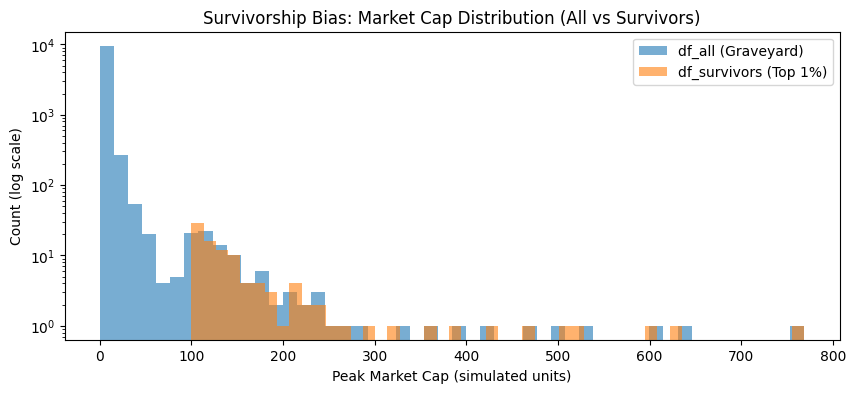

In [ ]:
plt.figure(figsize=(10,4))

# Use log scale to make the heavy tail visible
plt.hist(df_all["peak_market_cap"], bins=50, alpha=0.6, label="df_all (Graveyard)")
plt.hist(df_survivors["peak_market_cap"], bins=50, alpha=0.6, label="df_survivors (Top 1%)")

plt.yscale("log")  # counts differ hugely; log helps
plt.title("Survivorship Bias: Market Cap Distribution (All vs Survivors)")
plt.xlabel("Peak Market Cap (simulated units)")
plt.ylabel("Count (log scale)")
plt.legend()
plt.show()
